In [5]:
%pip install transformers 
%pip install datasets 
%pip install scikit-learn
%pip install torch
%pip install datasets
%pip install accelerate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

### **1. Loading the Data**
In this part, we load the dataset from a CSV file and preprocess it. We also convert the difficulty levels into numeric labels for classification.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Split the data into train (80%) and test (10%)

train_data = pd.read_csv("./data/french_difficulty_train.csv")
test_data = pd.read_csv("./data/french_difficulty_test.csv")

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

print(f"Train data difficulty distribution: {train_data['difficulty'].value_counts()}")
print(f"Test data difficulty distribution: {test_data['difficulty'].value_counts()}")
print(f"Duplicated rows in train data: {train_data.duplicated().sum()}")
print(f"Duplicated rows in test data: {test_data.duplicated().sum()}")

label2id = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
id2label = {v: k for k, v in label2id.items()}

train_data['labels'] = train_data['difficulty'].map(label2id)
test_data['labels'] = test_data['difficulty'].map(label2id)


# Display the first few rows of the train data
print("Train data sample:")
print(train_data.head())

Train size: 3840
Test size: 960
Train data difficulty distribution: difficulty
A1    640
A2    640
B1    640
B2    640
C1    640
C2    640
Name: count, dtype: int64
Test data difficulty distribution: difficulty
A1    160
A2    160
B1    160
B2    160
C1    160
C2    160
Name: count, dtype: int64
Duplicated rows in train data: 0
Duplicated rows in test data: 0
Train data sample:
                                    sentence difficulty  labels
0  Est-ce que le professeur Omar est libre ?         A1       0
1                              Elle a 21 ans         A1       0
2                  Alors comment ça marche ?         A1       0
3                                A bientôt !         A1       0
4        Le chaufffeur de bus est en retard.         A1       0



### **3. Preparing the Hugging Face Dataset**
In this step, we convert the dataset into the Hugging Face `Dataset` format and create a `DatasetDict` for easier handling in the `transformers` library.

In [4]:
# Convert to Hugging Face Dataset format
test_dataset = Dataset.from_pandas(test_data)
train_dataset = Dataset.from_pandas(train_data)

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_data),
    "test": Dataset.from_pandas(test_data),
})

# Check sample
print(dataset["train"][0])

print(dataset)

{'sentence': 'Est-ce que le professeur Omar est libre ?', 'difficulty': 'A1', 'labels': 0}
DatasetDict({
    train: Dataset({
        features: ['sentence', 'difficulty', 'labels'],
        num_rows: 3840
    })
    test: Dataset({
        features: ['sentence', 'difficulty', 'labels'],
        num_rows: 960
    })
})



### **4. Tokenizing the Dataset**
Here, we load the tokenizer for `xlm-roberta-base` and tokenize the sentences. We also assign numeric labels for classification.

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

def tokenize_function(examples):
    # No need to remap labels, they're already integer!
    result = tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    result["labels"] = examples["labels"]  # <- keep the integer label
    return result

tokenized_datasets = dataset.map(tokenize_function, batched=True)
print(tokenized_datasets["train"][0])


Map:   0%|          | 0/3840 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

{'sentence': 'Est-ce que le professeur Omar est libre ?', 'difficulty': 'A1', 'labels': 0, 'input_ids': [0, 12566, 9, 329, 41, 95, 166104, 112493, 437, 11506, 705, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}



### **5. Loading the Model**
In this step, we load the pre-trained `xlm-roberta-base` model and prepare it for sequence classification by specifying the number of labels.

In [6]:
import torch
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")


Using device: mps


In [7]:
from transformers import AutoModelForSequenceClassification

# Define the number of classes (assuming data["difficulty"] is your dataframe/series)
num_classes = len(train_data["difficulty"].unique())
print(f"Number of classes: {num_classes}")

# Load CamemBERT model
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=num_classes)

model.to(device)  # Move the model to the device


Number of classes: 6


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=


### **6. Setting Up the Trainer**
We define the training arguments and initialize the `Trainer` class, which manages the fine-tuning process. Early stopping is implemented to prevent overfitting.


In [8]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback

# Define a data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,  # Adjusted learning rate
    lr_scheduler_type="linear",  # Gradually reduces learning rate
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.2,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)


/Users/dimitriroulin/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/wb/btfl8bv91b5c253kbpftk1940000gn/T/ipykernel_23733/4216458826.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### **7. Training the Model**
Finally, we start the training process and fine-tune the model for the text classification task.


In [9]:
# Train the model
trainer.train()

  0%|          | 0/2400 [00:00<?, ?it/s]

{'loss': 1.8003, 'grad_norm': 4.6069159507751465, 'learning_rate': 9.958333333333334e-06, 'epoch': 0.04}
{'loss': 1.8083, 'grad_norm': 4.21975564956665, 'learning_rate': 9.916666666666668e-06, 'epoch': 0.08}
{'loss': 1.7887, 'grad_norm': 9.640000343322754, 'learning_rate': 9.875000000000001e-06, 'epoch': 0.12}
{'loss': 1.7829, 'grad_norm': 11.217028617858887, 'learning_rate': 9.833333333333333e-06, 'epoch': 0.17}
{'loss': 1.7855, 'grad_norm': 6.624171733856201, 'learning_rate': 9.791666666666666e-06, 'epoch': 0.21}
{'loss': 1.7367, 'grad_norm': 13.779239654541016, 'learning_rate': 9.75e-06, 'epoch': 0.25}
{'loss': 1.7268, 'grad_norm': 16.771909713745117, 'learning_rate': 9.708333333333333e-06, 'epoch': 0.29}
{'loss': 1.6893, 'grad_norm': 15.949212074279785, 'learning_rate': 9.666666666666667e-06, 'epoch': 0.33}
{'loss': 1.6686, 'grad_norm': 10.97515869140625, 'learning_rate': 9.625e-06, 'epoch': 0.38}
{'loss': 1.667, 'grad_norm': 24.642927169799805, 'learning_rate': 9.583333333333335e-

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 1.2014480829238892, 'eval_runtime': 22.7257, 'eval_samples_per_second': 42.243, 'eval_steps_per_second': 5.28, 'epoch': 1.0}
{'loss': 1.227, 'grad_norm': 27.144868850708008, 'learning_rate': 8.958333333333334e-06, 'epoch': 1.04}
{'loss': 1.2321, 'grad_norm': 50.0009651184082, 'learning_rate': 8.916666666666667e-06, 'epoch': 1.08}
{'loss': 1.2331, 'grad_norm': 30.357746124267578, 'learning_rate': 8.875e-06, 'epoch': 1.12}
{'loss': 1.2367, 'grad_norm': 43.24317932128906, 'learning_rate': 8.833333333333334e-06, 'epoch': 1.17}
{'loss': 1.3197, 'grad_norm': 17.572240829467773, 'learning_rate': 8.791666666666667e-06, 'epoch': 1.21}
{'loss': 1.3814, 'grad_norm': 42.08796310424805, 'learning_rate': 8.750000000000001e-06, 'epoch': 1.25}
{'loss': 1.1728, 'grad_norm': 18.4337158203125, 'learning_rate': 8.708333333333334e-06, 'epoch': 1.29}
{'loss': 1.1675, 'grad_norm': 26.939029693603516, 'learning_rate': 8.666666666666668e-06, 'epoch': 1.33}
{'loss': 1.2214, 'grad_norm': 40.0050621

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 1.1373502016067505, 'eval_runtime': 18.6646, 'eval_samples_per_second': 51.434, 'eval_steps_per_second': 6.429, 'epoch': 2.0}
{'loss': 1.0505, 'grad_norm': 29.529321670532227, 'learning_rate': 7.958333333333333e-06, 'epoch': 2.04}
{'loss': 1.0752, 'grad_norm': 48.957275390625, 'learning_rate': 7.916666666666667e-06, 'epoch': 2.08}
{'loss': 1.1341, 'grad_norm': 36.9029655456543, 'learning_rate': 7.875e-06, 'epoch': 2.12}
{'loss': 1.0399, 'grad_norm': 24.912622451782227, 'learning_rate': 7.833333333333333e-06, 'epoch': 2.17}
{'loss': 1.0291, 'grad_norm': 86.4991226196289, 'learning_rate': 7.791666666666667e-06, 'epoch': 2.21}
{'loss': 1.0101, 'grad_norm': 24.425342559814453, 'learning_rate': 7.75e-06, 'epoch': 2.25}
{'loss': 1.1306, 'grad_norm': 126.0659408569336, 'learning_rate': 7.708333333333334e-06, 'epoch': 2.29}
{'loss': 1.0109, 'grad_norm': 47.700889587402344, 'learning_rate': 7.666666666666667e-06, 'epoch': 2.33}
{'loss': 0.9991, 'grad_norm': 37.16753005981445, 'lea

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 1.0806792974472046, 'eval_runtime': 19.9128, 'eval_samples_per_second': 48.21, 'eval_steps_per_second': 6.026, 'epoch': 3.0}
{'loss': 0.9213, 'grad_norm': 40.27290344238281, 'learning_rate': 6.958333333333333e-06, 'epoch': 3.04}
{'loss': 0.9238, 'grad_norm': 49.73056411743164, 'learning_rate': 6.916666666666667e-06, 'epoch': 3.08}
{'loss': 0.9105, 'grad_norm': 55.387969970703125, 'learning_rate': 6.875e-06, 'epoch': 3.12}
{'loss': 0.8787, 'grad_norm': 40.28156280517578, 'learning_rate': 6.833333333333334e-06, 'epoch': 3.17}
{'loss': 1.0198, 'grad_norm': 33.4080696105957, 'learning_rate': 6.791666666666667e-06, 'epoch': 3.21}
{'loss': 0.9525, 'grad_norm': 33.2118034362793, 'learning_rate': 6.750000000000001e-06, 'epoch': 3.25}
{'loss': 0.9178, 'grad_norm': 37.913970947265625, 'learning_rate': 6.708333333333333e-06, 'epoch': 3.29}
{'loss': 0.9628, 'grad_norm': 52.445011138916016, 'learning_rate': 6.666666666666667e-06, 'epoch': 3.33}
{'loss': 0.9594, 'grad_norm': 71.3815689

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 1.1135891675949097, 'eval_runtime': 18.9318, 'eval_samples_per_second': 50.708, 'eval_steps_per_second': 6.339, 'epoch': 4.0}
{'loss': 0.8075, 'grad_norm': 151.2725372314453, 'learning_rate': 5.958333333333334e-06, 'epoch': 4.04}
{'loss': 0.7781, 'grad_norm': 44.644775390625, 'learning_rate': 5.916666666666667e-06, 'epoch': 4.08}
{'loss': 0.8579, 'grad_norm': 41.0768928527832, 'learning_rate': 5.8750000000000005e-06, 'epoch': 4.12}
{'loss': 0.9167, 'grad_norm': 39.78550338745117, 'learning_rate': 5.833333333333334e-06, 'epoch': 4.17}
{'loss': 0.9123, 'grad_norm': 63.009944915771484, 'learning_rate': 5.791666666666667e-06, 'epoch': 4.21}
{'loss': 0.8795, 'grad_norm': 108.9716796875, 'learning_rate': 5.75e-06, 'epoch': 4.25}
{'loss': 0.8033, 'grad_norm': 44.23639678955078, 'learning_rate': 5.7083333333333335e-06, 'epoch': 4.29}
{'loss': 0.8251, 'grad_norm': 44.403926849365234, 'learning_rate': 5.666666666666667e-06, 'epoch': 4.33}
{'loss': 0.9611, 'grad_norm': 48.6049346923

  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 1.2749117612838745, 'eval_runtime': 20.6737, 'eval_samples_per_second': 46.436, 'eval_steps_per_second': 5.804, 'epoch': 5.0}
{'train_runtime': 1769.5085, 'train_samples_per_second': 21.701, 'train_steps_per_second': 1.356, 'train_loss': 1.111526881456375, 'epoch': 5.0}


TrainOutput(global_step=1200, training_loss=1.111526881456375, metrics={'train_runtime': 1769.5085, 'train_samples_per_second': 21.701, 'train_steps_per_second': 1.356, 'total_flos': 1262978423193600.0, 'train_loss': 1.111526881456375, 'epoch': 5.0})

### **8. Evaluating the Model**
Evaluate the model on the test set to check its performance using metrics like accuracy, precision, recall, and F1-score.

In [10]:
# Evaluate the model
results = trainer.evaluate(tokenized_datasets["test"])
print(results)

# Compute additional metrics if needed
from sklearn.metrics import classification_report

# Extract true labels (y_true) from the test dataset
y_true = test_data["difficulty"].map(label2id).tolist()


# Predict the labels using the trained model
y_pred = trainer.predict(tokenized_datasets["test"]).predictions.argmax(axis=-1)

# Generate the classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


  0%|          | 0/120 [00:00<?, ?it/s]

{'eval_loss': 1.0806792974472046, 'eval_runtime': 18.9391, 'eval_samples_per_second': 50.689, 'eval_steps_per_second': 6.336, 'epoch': 5.0}


  0%|          | 0/120 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.63      0.72      0.68       160
           1       0.49      0.46      0.47       160
           2       0.50      0.54      0.52       160
           3       0.47      0.42      0.44       160
           4       0.48      0.51      0.49       160
           5       0.64      0.56      0.60       160

    accuracy                           0.54       960
   macro avg       0.53      0.54      0.53       960
weighted avg       0.53      0.54      0.53       960



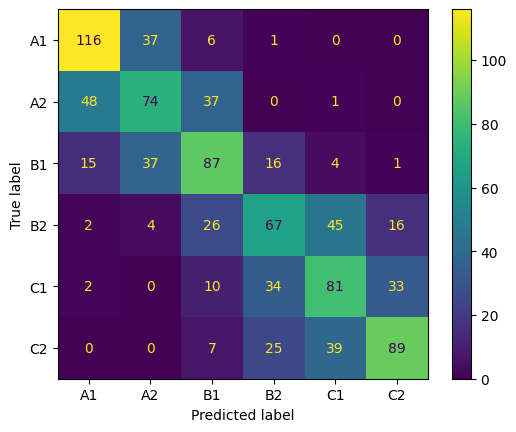

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["A1", "A2", "B1", "B2", "C1", "C2"])
disp.plot(cmap="viridis")


In [27]:
# Predict on test set
pred_outputs = trainer.predict(tokenized_datasets["test"])
y_pred = pred_outputs.predictions.argmax(axis=-1)


  0%|          | 0/120 [00:00<?, ?it/s]

In [12]:
import pandas as pd

# 1. Predict with your trained CamemBERT model
pred_outputs = trainer.predict(tokenized_datasets["test"])
y_pred = pred_outputs.predictions.argmax(axis=-1)

# 2. Map integer predictions to CEFR labels (if needed)
id2label = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
pred_labels = [id2label[i] for i in y_pred]

# 3. Prepare DataFrame
df_pred = pd.DataFrame({
    "sentence": test_data["sentence"].tolist(),
    "difficulty": test_data["difficulty"].tolist(),  # true label (string)
    "predictions_xlm-roberta-base": pred_labels
})

# 4. Save to CSV with requested filename
df_pred.to_csv("predictions_xlm-roberta-base.csv", index=False)
print("✅ Saved: predictions_xlm-roberta-base.csv")


  0%|          | 0/120 [00:00<?, ?it/s]

✅ Saved: predictions_xlm-roberta-base.csv


# Pairewise Mismmatch metric
The pairwise mismatch metric focuses on computing ordering violations in predictions relative to ground truth.
<img src="./Images/Pairewise-Matchinge-Explanation.png" width="800px">

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def pairwise_mismatch(y_pred: pd.Series, y_real: pd.Series) -> float:
    """
    Compute the pairwise mismatch metric as described by Henry Jamet.
    
    :param y_pred: Pandas Series of predicted difficulty levels
    :param y_real: Pandas Series of true difficulty levels
    :return: Mean pairwise mismatch score
    """
    predictions = pd.DataFrame({"pred": y_pred, "real": y_real})

    # Sort alphabetically by real and predicted labels
    predictions = predictions.sort_values(by=["real", "pred"])

    # Convert categorical labels into numeric values while keeping order
    predictions["pred"] = predictions["pred"].astype("category")
    predictions["real"] = predictions["real"].astype("category")

    # Initialize LabelEncoder and encode labels
    label_encoder = LabelEncoder()
    unique_labels = pd.unique(predictions[["pred", "real"]].values.ravel("K"))
    label_encoder.fit(unique_labels)

    predictions["pred"] = label_encoder.transform(predictions["pred"])
    predictions["real"] = label_encoder.transform(predictions["real"])

    # Compute the pairwise mismatch
    mismatch = (
        predictions["pred"].expanding().apply(lambda s: (s.iloc[-1] - s < 0).sum())
        + predictions["pred"][::-1]
        .expanding()
        .apply(lambda s: (s.iloc[-1] - s > 0).sum())[::-1]
    )

    return mismatch.mean()

# Convert y_true and y_pred into pandas Series
y_true_series = pd.Series(y_true)
y_pred_series = pd.Series(y_pred)

# Compute the pairwise mismatch
mismatch_score = pairwise_mismatch(y_pred_series, y_true_series)
print(f"Pairwise Mismatch Score: {mismatch_score:.4f}")


Pairwise Mismatch Score: 49.5250
